This notebook contains the code to perform Exploratory Data Analysis for the Tanzanian water pump survey.


In [3]:
import os
import csv 
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

# load local modules
import run_Pandas_Profiling
import pct_3portion_plot


In [4]:
# initialize run parameters
t0 = datetime.now()
timestamp = t0.strftime("%Y%m%d-%H%M%S")
log_file = 'results' + timestamp + '.txt'
logging.basicConfig(filename=log_file, filemode='w', level=logging.INFO, format='%(message)s')
logging.info('Starting EDA')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
              
# set path to dataset created in cleaning stage
working_file = 'ds_clean.csv'

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
text_size = 18


In [5]:
#read dataset created in cleaning stage
df_clean = pd.read_csv(working_file)

In [6]:
#confirm number of observations and features
df_clean.shape

(59399, 13)

In [8]:
# Make a copy of the original dataset, sort the column names for consistency, create a unique ID
# and visually examine a sample of the data
df_eda = df_clean.reindex(columns=sorted(df_clean.columns))
df_eda.rename(columns={"Unnamed: 0": "id"}, inplace=True)
df_eda.head()

,id,basin,construction_year,extraction_type_class,gps_height,management_group,payment_type,permit,quantity,region,source,status_group,waterpoint_type
0,0,Lake Nyasa,1999,gravity,1390,user-group,other,False,enough,Iringa,spring,functional,communal standpipe
1,2,Pangani,2009,gravity,686,user-group,per bucket,True,enough,Manyara,other,functional,communal standpipe multiple
2,3,Ruvuma / Southern Coast,1986,submersible,263,user-group,never pay,True,dry,Mtwara,machine dbh,non functional,communal standpipe multiple
3,4,Lake Victoria,0,gravity,0,other,never pay,True,seasonal,Kagera,other,functional,communal standpipe
4,5,Pangani,2009,submersible,0,user-group,per bucket,True,enough,Tanga,other,functional,communal standpipe multiple


#### Questions to explore

1. What is the distribution of pump status values?

2. How does the pump status vary over features that would intuitively seem to have an impact on the functional status? We will examine construction year, pump type, management, geographic location, altitude, payment type, permit status, quantity of water, source of water, and waterpoint type.

3. Can we gain insights from seeing the pumps mapped by latitude and longitude?

## 1. What is the distribution of pump status values?

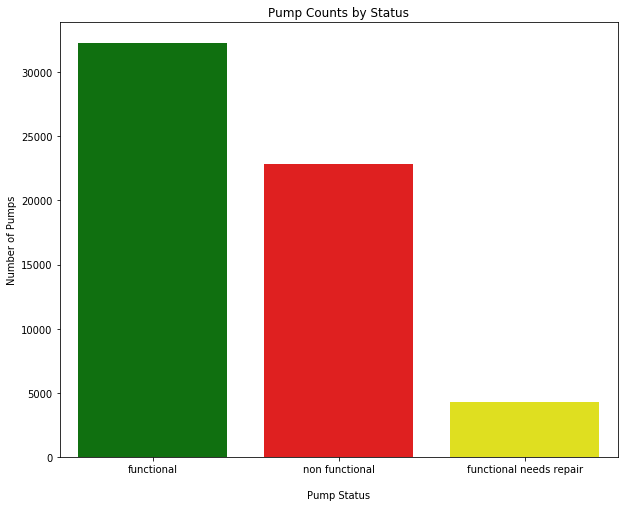

In [9]:
snsplot = sns.countplot(x='status_group',data=df_eda, palette=['green', 'red', 'yellow'])

snsplot.set(xlabel='\nPump Status', ylabel='Number of Pumps', title='Pump Counts by Status')
plt.show()
fig = snsplot.get_figure()
fig.savefig('Pumps_by_status.png', bbox_inches='tight', pad_inches=0.02)

## 2a. How does the age of the pump affect operational status?

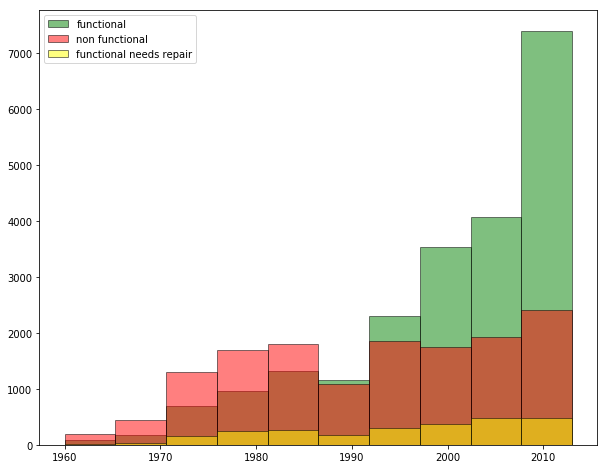

In [10]:
df_age_status = df_eda[df_eda['construction_year']>0][['construction_year', 'status_group']]

df_age_functional = df_age_status[(df_age_status['status_group']=='functional')]
df_age_nonfunctional = df_age_status[(df_age_status['status_group']=='non functional')]
df_age_needsrepair = df_age_status[(df_age_status['status_group']=='functional needs repair')]

plt.style.use('seaborn-deep')  
bins = 10
plt.hist(df_age_functional['construction_year'], alpha=0.5, label='functional', color='green', edgecolor = 'black')
plt.hist(df_age_nonfunctional['construction_year'], alpha=0.5, label='non functional', color='red', edgecolor = 'black')
plt.hist(df_age_needsrepair['construction_year'], alpha=0.5, label='functional needs repair', color='yellow', edgecolor = 'black')
plt.legend(loc='upper left')
plt.savefig('Pump_Status_by_Year.png', bbox_inches='tight', pad_inches=0.02)
plt.show()


From this histogram we can see that pumps built before 1990 are non-functional more than they are functional. After 1990, the number of functional pumps increases, and the total number of pumps has increased dramatically. 

Interestingly, there are 156 pumps built in the 1960's that are still working, 40 years later! It would be a good exercise to study the characteristics of those pumps and meet with the communities who use those pumps to try to identify the success factors there, and then try and replicate those factors elsewhere.

In [202]:
len(df_age_functional[df_age_functional['construction_year']<1970])

156

Unfortunately, 30% of the pumps do not have a construction year recorded, so the predictive quality of this feature may not be very strong.

## 2b. How does is the pump status distributed over different basins?

In [274]:
df_basin = pd.crosstab(index = ds_eda['status_group'], 
            columns = ds_eda['basin']) 
df_basin


basin,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu
status_group,,,,,,,,,
functional,4482,3324,1000,3107,5100,5372,5068,1670,3136
functional needs repair,557,250,270,742,989,477,437,326,269
non functional,2746,1511,1184,2583,4159,3091,2471,2497,2582


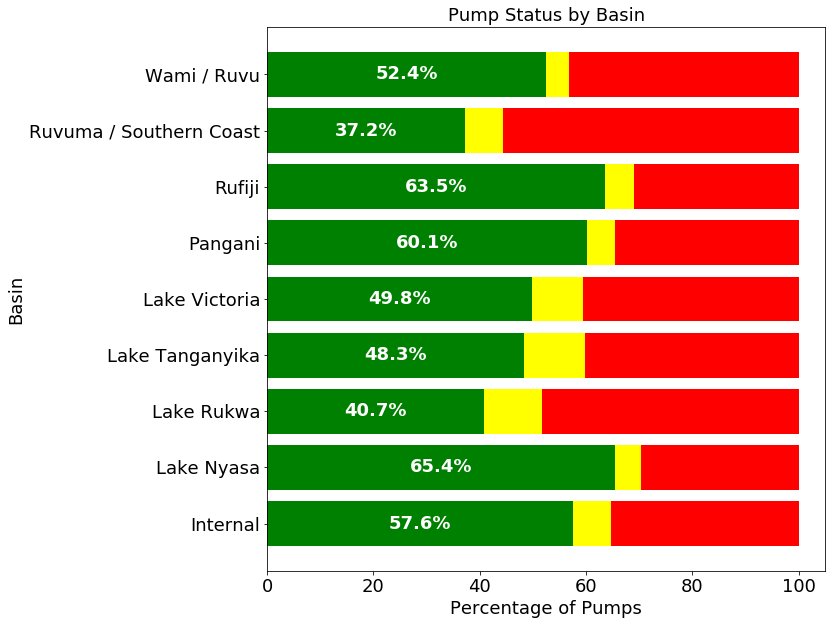

In [272]:
#warning - the order of x must match the order in the dataframe
x=df_basin.columns
y1 = np.array(df_basin.loc['functional'])
y2 = np.array(df_basin.loc['functional needs repair'])
y3 = np.array(df_basin.loc['non functional'])

pct_3portion_plot(x, y1, y2, y3, 0, 10, 10, "Basin", "Pump Status by Basin", "Pump_Status_by_Basin", True)


## 2c. Does operational status differ by the type of pump?

In [13]:
df_ext_type = pd.crosstab(index = df_eda['extraction_type_class'], 
            columns = df_eda['status_group']) 
df_ext_type

status_group,functional,functional needs repair,non functional
extraction_type_class,,,
gravity,16047,2701,8031
handpump,10375,995,5086
motorpump,1135,138,1714
other,1372,230,5396
submersible,3329,253,2597


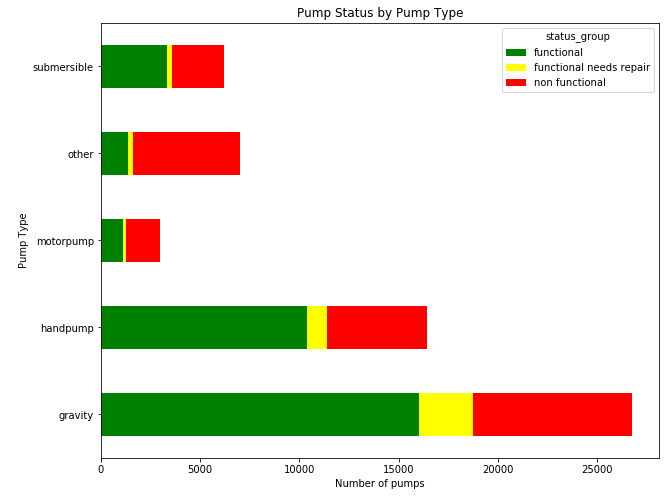

In [14]:
# plot directly from the crosstab

ax = df_ext_type.plot.barh(stacked=True, color=['green', 'yellow', 'red'])

ax.set_xlabel('Number of pumps')
ax.set_ylabel('\nPump Type')
ax.set_title('Pump Status by Pump Type')

plt.savefig('Pump_Status_by_Pump_Type.png', bbox_inches='tight', pad_inches=0.02)

plt.show()


This plot indicates that the pump status varies by pump type.  It also shows that the two smallest categories, "rope pump" and "wind-powered", can be combined into the "other" category to help reduce the cardinality for this feature.

## 2d. Does the management of the pump affect its functional status?

In [150]:
df_mgmt_type = pd.crosstab(index = ds_eda['management_group'], 
            columns = ds_eda['status_group']) 
df_mgmt_type

status_group,functional,functional needs repair,non functional
management_group,,,
commercial,2235,117,1286
other,528,56,359
parastatal,1020,211,537
unknown,224,27,310
user-group,28252,3906,20332


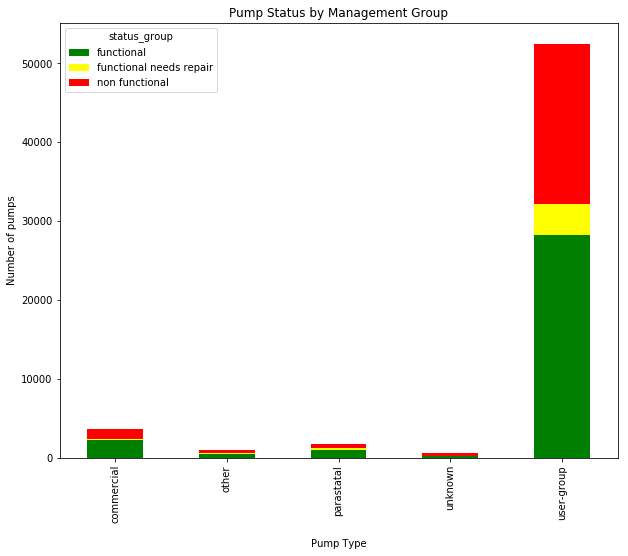

In [206]:
# plot directly from the crosstab

ax = df_mgmt_type.plot.bar(stacked=True, color=['green', 'yellow', 'red'])

ax.set_ylabel('Number of pumps')
ax.set_xlabel('\nPump Type')
ax.set_title('Pump Status by Management Group')

plt.savefig('Pump_Status_by_Mgmt_Group.png', bbox_inches='tight', pad_inches=0.02)

plt.show()


This plot indicates that the pump status varies by management type.  It also shows that majority the "unknown" category can be combined into the "other" category to help reduce the cardinality for this feature. Since the almost all of the data is in one managment type, this feature might not constribute much to the predictions.

## Does the geographic location of the pump affect its functional status?

In [205]:
df_geo = pd.crosstab(index = ds_eda['region'], 
            columns = ds_eda['status_group']) 
df_geo

status_group,functional,functional needs repair,non functional
region,,,
Arusha,2294,175,881
Dar es Salaam,461,3,341
Dodoma,1009,209,983
Iringa,4141,123,1030
Kagera,1727,304,1285
Kigoma,1363,603,850
Kilimanjaro,2640,322,1417
Lindi,460,93,993
Manyara,987,96,500


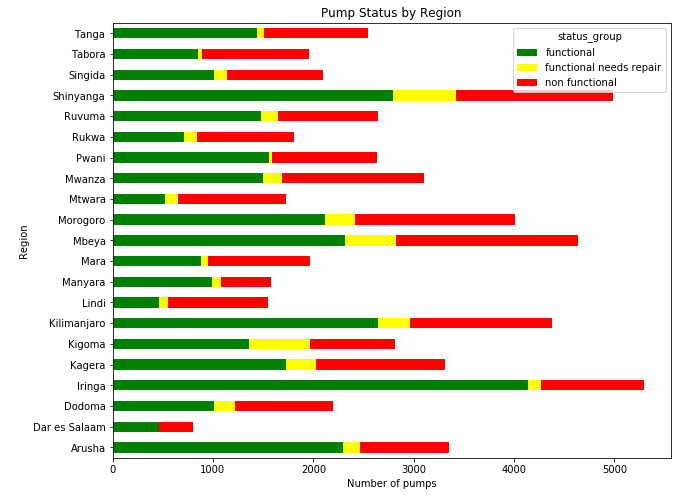

In [207]:
# plot directly from the crosstab

ax = df_geo.plot.barh(stacked=True, color=['green', 'yellow', 'red'])

ax.set_xlabel('Number of pumps')
ax.set_ylabel('\nRegion')
ax.set_title('Pump Status by Region')

plt.savefig('Pump_Status_by_Region.png', bbox_inches='tight', pad_inches=0.02)

plt.show()


This plot indicates that the pump status varies by geographic region.  

Given that there are no drastic imbalances in representation by region, viewing the percentages is a better way to see the proportion of pump statuses in each region.

In [217]:
df_geo = pd.crosstab(index = ds_eda['status_group'], 
            columns = ds_eda['region']) 
df_geo.sort_values(by='region', axis=1, ascending=True, inplace=True)

df_geo

region,Arusha,Dar es Salaam,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Mwanza,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga
status_group,,,,,,,,,,,,,,,,,,,,,
functional,2294,461,1009,4141,1727,1363,2640,460,987,886,2319,2119,524,1502,1556,707,1480,2789,1011,848,1436
functional needs repair,175,3,209,123,304,603,322,93,96,60,504,300,126,183,36,135,164,635,128,45,73
non functional,881,341,983,1030,1285,850,1417,993,500,1023,1816,1587,1080,1417,1043,966,996,1558,954,1066,1038


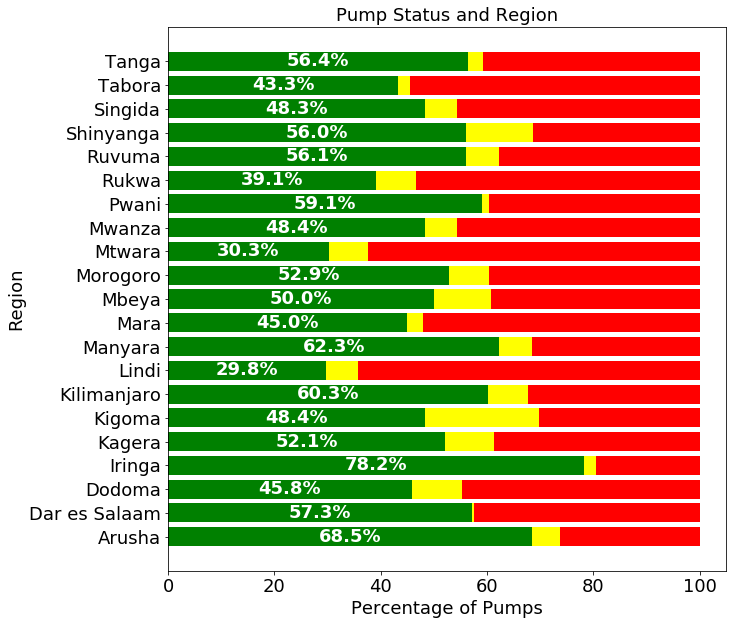

In [273]:
#warning - the order of x must match the order in the dataframe
x=sorted(df_geo.columns)
y1 = np.array(df_geo.loc['functional'])
y2 = np.array(df_geo.loc['functional needs repair'])
y3 = np.array(df_geo.loc['non functional'])
text_size = 18
pct_3portion_plot(x, y1, y2, y3, 0, 10, 10, "Region", "Pump Status and Region", "Pump_Status_by_Region", True)



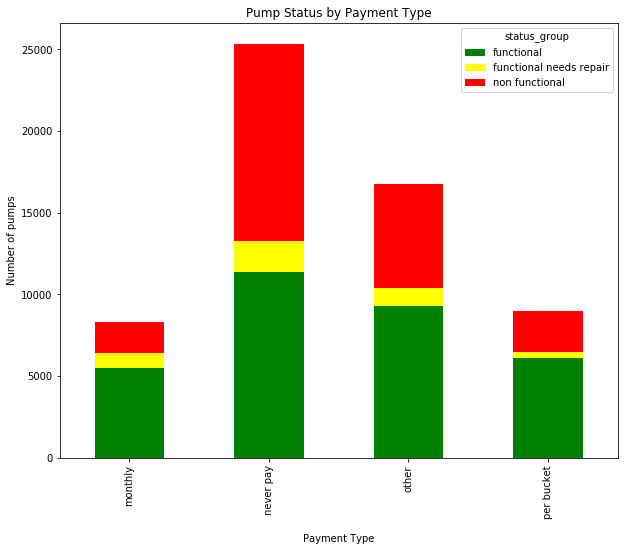

In [282]:
df_payment_type = pd.crosstab(index = ds_eda['payment_type'], 
            columns = ds_eda['status_group']) 
ax = df_payment_type.plot.bar(stacked=True, color=['green', 'yellow', 'red'])

ax.set_ylabel('Number of pumps')
ax.set_xlabel('\nPayment Type')
ax.set_title('Pump Status by Payment Type')

plt.savefig('Pump_Status_by_Payment_Type.png', bbox_inches='tight', pad_inches=0.02)

plt.show()

The plot shows that the "never pay" category contains the most values. If the funds for pump repair depended on profitability of the pump, this could explain why many pumps are non functional.

In [288]:
df_permit = pd.crosstab(index = ds_eda['permit'], 
            columns = ds_eda['status_group'], normalize=True) 

print('Pump Status by Permit Status')
df_permit

Pump Status by Permit Status


status_group,functional,functional needs repair,non functional
permit,,,
False,0.161987,0.023906,0.125724
True,0.381094,0.048771,0.258519


This crosstab shows that most pumps have a permit, and the proportion of functional pumps is higher for pumps with a permit rather than those without one.

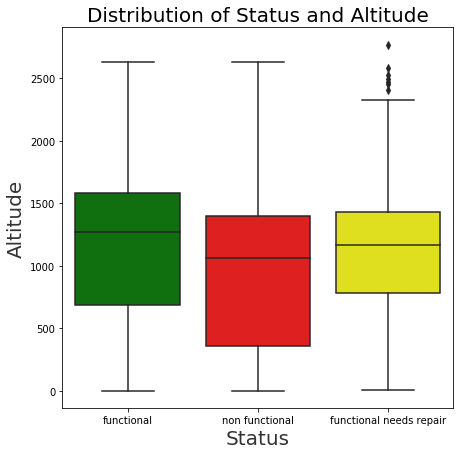

In [275]:
ds_nonzero_gps = ds_eda[ds_eda['gps_height']>0]
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.boxplot(x="status_group", y="gps_height", data=ds_nonzero_gps, palette=['green', 'red', 'yellow'])
ax.set_xlabel("Status",size = 20,alpha=0.8)
ax.set_ylabel("Altitude",size = 20,alpha=0.8)
ax.set_title("Distribution of Status and Altitude",size=20)
plt.show()


The box plot shows that there is higher variability in altitudes, especially lower altitudes, for pumps in a non-functional status. Also, there are outliers in the altitude values for pumps that are functional and need repair, while at the same time, 50% of the bumps are in a small range of altitudes. The pumps with the highest altitude values are in the Arusha region, which contains Mount Meru.

In [281]:
ds_mountains = ds_nonzero_gps.sort_values(by=['gps_height'], ascending=False)
ds_mountains[['gps_height','region']].head(10)

,gps_height,region
17374,2770,Arusha
40822,2628,Arusha
12905,2627,Arusha
35453,2626,Arusha
21388,2626,Arusha
465,2623,Arusha
54394,2614,Arusha
42014,2585,Arusha
43533,2576,Arusha
1202,2569,Arusha


Unfortunately the <b>gps_height</b> feature contains 34% zero/missing observations, so this might not contribute much to the model's ability to predict the pump status.

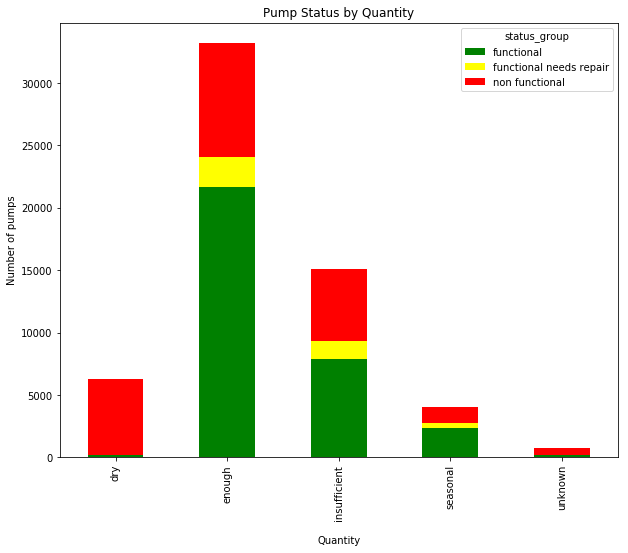

In [295]:
df_quantity = pd.crosstab(index = df_eda['quantity'], 
            columns = df_eda['status_group']) 
ax = df_quantity.plot.bar(stacked=True, color=['green', 'yellow', 'red'])

ax.set_ylabel('Number of pumps')
ax.set_xlabel('\nQuantity')
ax.set_title('Pump Status by Quantity')

plt.savefig('Pump_Status_by_Quantity.png', bbox_inches='tight', pad_inches=0.02)

plt.show()

This plot shows a potential error in the data with a pump listed as 'dry' but still functional.

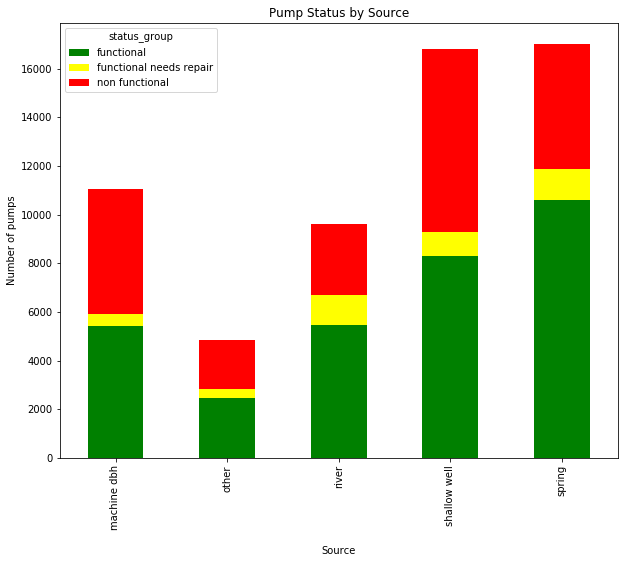

In [297]:
df_source = pd.crosstab(index = df_eda['source'], 
            columns = df_eda['status_group']) 
ax = df_source.plot.bar(stacked=True, color=['green', 'yellow', 'red'])

ax.set_ylabel('Number of pumps')
ax.set_xlabel('\nSource')
ax.set_title('Pump Status by Source')

plt.savefig('Pump_Status_by_Source.png', bbox_inches='tight', pad_inches=0.02)

plt.show()

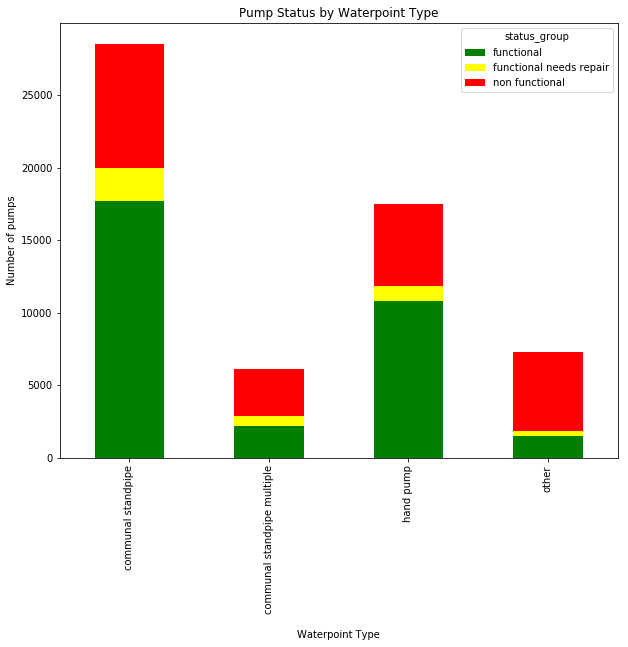

In [298]:
df_wp = pd.crosstab(index = df_eda['waterpoint_type'], 
            columns = df_eda['status_group']) 
ax = df_wp.plot.bar(stacked=True, color=['green', 'yellow', 'red'])

ax.set_ylabel('Number of pumps')
ax.set_xlabel('\nWaterpoint Type')
ax.set_title('Pump Status by Waterpoint Type')

plt.savefig('Pump_Status_by_WPType.png', bbox_inches='tight', pad_inches=0.02)

plt.show()